# Análisis predictivo de la evasión de clientes

Se carga la base de datos que se obtuvo del análisis descriptivo de datos de la base de clientes

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

url = "https://raw.githubusercontent.com/ltobes/TelecomX/refs/heads/main/df_telecomX.csv"
clientes = pd.read_csv(url)

## Preparación de datos (preprocesamiento)
 Se vuelve a realizar una corroboración de la existencia o no de valores nulos, con el fin de corroborar que la base de datos se cargo correctamente. Se odifican las variables categóricas usando One-Hot Encoding, normalizar o escalar variables numéricas si es necesario para los modelos a utilizar se dividen los datos en conjuntos de entrenamiento y prueba.


In [52]:
print("Valores nulos por columna:")
print(clientes.isnull().sum())

# Convertir 'Charges.Total' a numérico, manejando posibles errores
clientes['Charges.Total'] = pd.to_numeric(clientes['Charges.Total'], errors='coerce')

# Rellenar los valores nulos creados por la conversión con la mediana
clientes['Charges.Total'].fillna(clientes['Charges.Total'].median(), inplace=True)

print("\nValores nulos después del tratamiento:")
print(clientes.isnull().sum())

# Identificar columnas categóricas y numéricas
categorical_cols = clientes.select_dtypes(include=['object']).columns.tolist()
numerical_cols = clientes.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Excluir 'customerID' y 'Churn' de las características
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')
if 'Churn' in numerical_cols:
    numerical_cols.remove('Churn')

print("\nColumnas categóricas:", categorical_cols)
print("Columnas numéricas:", numerical_cols)

Valores nulos por columna:
customerID          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges.Monthly     0
Charges.Total       0
Charge.Diary        0
dtype: int64

Valores nulos después del tratamiento:
customerID          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Charges.Monthly   

/tmp/ipython-input-674986485.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clientes['Charges.Total'].fillna(clientes['Charges.Total'].median(), inplace=True)


In [53]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Crear transformadores para columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Mantener otras columnas (como customerID si no fue removida)
)

# Aplicar el preprocesamiento a los datos
clientes_processed = preprocessor.fit_transform(clientes)

# Convertir el resultado a DataFrame para facilitar la visualización (opcional)
# Esto puede ser complejo debido a la codificación one-hot, pero es útil para inspección
# Obtener los nombres de las columnas después del one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(ohe_feature_names) + ['customerID', 'Churn'] # Ajustar si 'customerID' o 'Churn' no están en remainder

# Intentar crear el DataFrame - puede requerir ajustes dependiendo de 'remainder'
try:
    clientes_processed_df = pd.DataFrame(clientes_processed, columns=all_feature_names)
    display(clientes_processed_df.head())
except ValueError as e:
    print(f"No se pudo crear el DataFrame procesado directamente: {e}")
    print("El preprocesamiento se ha aplicado correctamente al array numpy.")

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,Charges.Monthly,Charges.Total,Charge.Diary,gender_Female,...,StreamingMovies_Yes,Contract_month to month,Contract_one year,Contract_two year,PaymentMethod_bank transfer (automatic),PaymentMethod_credit card (automatic),PaymentMethod_electronic check,PaymentMethod_mailed check,customerID,Churn
0,-0.441135,1.033356,1.53094,-0.952728,0.328051,0.827229,0.028037,-0.743818,0.028037,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0002-ORFBO,0
1,-0.441135,-0.96772,-0.653193,-0.952728,0.328051,-1.208855,-0.161183,-0.766256,-0.161183,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0003-MKNFE,0
2,-0.441135,-0.96772,-0.653193,-1.156341,0.328051,0.827229,0.303568,-0.881554,0.303568,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0004-TLHLJ,1
3,2.266881,1.033356,-0.653193,-0.789837,0.328051,0.827229,1.103603,-0.459685,1.103603,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0011-IGKFF,1
4,2.266881,1.033356,-0.653193,-1.197063,0.328051,0.827229,0.635533,-0.887483,0.635533,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0013-EXCHZ,1


In [54]:
from sklearn.model_selection import train_test_split

# Separar la variable objetivo (Churn)
X = clientes_processed_df.drop(['Churn', 'customerID'], axis=1) # Excluir 'customerID' también
y = clientes_processed_df['Churn']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dimensiones del conjunto de entrenamiento (X_train, y_train):", X_train.shape, y_train.shape)
print("Dimensiones del conjunto de prueba (X_test, y_test):", X_test.shape, y_test.shape)

Dimensiones del conjunto de entrenamiento (X_train, y_train): (5804, 42) (5804,)
Dimensiones del conjunto de prueba (X_test, y_test): (1452, 42) (1452,)


## Análisis de correlación y selección de variables

En este apartado se calcula la matriz de correlación para identificar relaciones entre variables, especialmente con la variable objetivo (`Churn`), y seleccionar las variables que se utilizarán para entrenar los modelos.


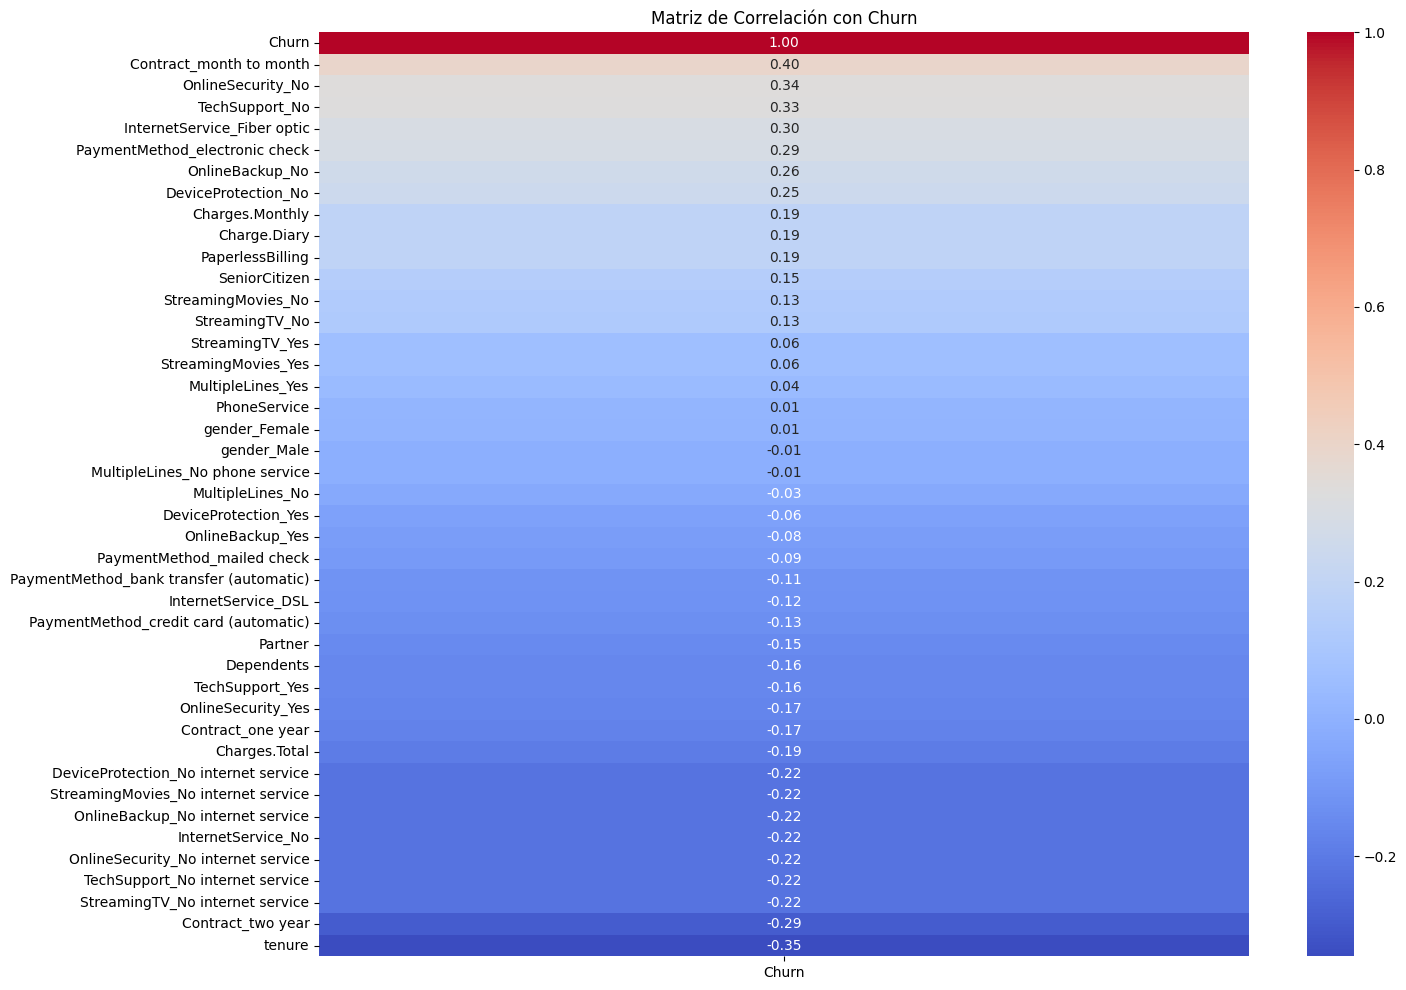


Correlación de variables con 'Churn':
Churn                                      1.000000
Contract_month to month                    0.395067
OnlineSecurity_No                          0.335271
TechSupport_No                             0.330060
InternetService_Fiber optic                0.300416
PaymentMethod_electronic check             0.294181
OnlineBackup_No                            0.262721
DeviceProtection_No                        0.246512
Charges.Monthly                            0.189393
Charge.Diary                               0.189393
PaperlessBilling                           0.186309
SeniorCitizen                              0.146400
StreamingMovies_No                         0.128793
StreamingTV_No                             0.126338
StreamingTV_Yes                            0.062456
StreamingMovies_Yes                        0.060092
MultipleLines_Yes                          0.039277
PhoneService                               0.012337
gender_Female            

In [55]:
import seaborn as sns

# Eliminar la columna 'customerID' antes de calcular la correlación
clientes_processed_numeric = clientes_processed_df.drop('customerID', axis=1)

# Asegurarse de que 'Churn' sea numérico para el cálculo de correlación si no lo es ya
# (Aunque el preprocesamiento debería haber manejado esto, es una buena verificación)
clientes_processed_numeric['Churn'] = pd.to_numeric(clientes_processed_numeric['Churn'])


# Calcular la matriz de correlación
correlation_matrix = clientes_processed_numeric.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix[['Churn']].sort_values(by='Churn', ascending=False), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación con Churn')
plt.show()

# Identificar variables con alta correlación con Churn
# Excluir la correlación de Churn consigo misma
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)
print("\nCorrelación de variables con 'Churn':")
print(churn_correlation)

# Seleccionar variables basadas en la correlación (ejemplo: correlación absoluta > 0.1)
# Excluir 'Churn' de la lista de features a considerar para X
correlated_features = churn_correlation[abs(churn_correlation) > 0.1].index.tolist()
if 'Churn' in correlated_features:
    correlated_features.remove('Churn') # Excluir la variable objetivo


print(f"\nVariables con correlación absoluta > 0.1 con 'Churn': {correlated_features}")


## Entrenamiento de modelos de clasificación

Se seleccionan dos modelos de clasificación adecuados para predecir `Churn` (por ejemplo, pueden ser: Regresión Logística, Árbol de Decisión, Random Forest, SVM, entre otros.) se seleccionó regresión logística y random forest y se entrenan los modelos seleccionados utilizando el conjunto de entrenamiento.


In [56]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

print("Entrenando modelo de Regresión Logística...")
log_reg_model.fit(X_train, y_train)
print("Regresión Logística entrenada.")

print("Entrenando modelo de Random Forest...")
rf_model.fit(X_train, y_train)
print("Random Forest entrenado.")

Entrenando modelo de Regresión Logística...
Regresión Logística entrenada.
Entrenando modelo de Random Forest...
Random Forest entrenado.


## Evaluación del rendimiento de los modelos

Se evaluan los modelos entrenados utilizando el conjunto de prueba, se calculan las métricas de evaluación relevantes para problemas de clasificación (Precisión, Recall, F1-Score, AUC) y se comparan los rendimientos de los diferentes modelos.


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [58]:
# Realizar predicciones con el conjunto de prueba
y_pred_log_reg = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Calcular métricas de evaluación para Regresión Logística
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)
auc_log_reg = roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1])

# Calcular métricas de evaluación para Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Imprimir las métricas de evaluación
print("Métricas de Evaluación - Regresión Logística:")
print(f"  Precisión: {precision_log_reg:.4f}")
print(f"  Recall: {recall_log_reg:.4f}")
print(f"  F1-Score: {f1_log_reg:.4f}")
print(f"  AUC: {auc_log_reg:.4f}")
print(f"  Accuracy: {accuracy_log_reg:.4f}")

print("\nMétricas de Evaluación - Random Forest:")
print(f"  Precisión: {precision_rf:.4f}")
print(f"  Recall: {recall_rf:.4f}")
print(f"  F1-Score: {f1_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")
print(f"  Accuracy: {accuracy_rf:.4f}")

Métricas de Evaluación - Regresión Logística:
  Precisión: 0.6196
  Recall: 0.5401
  F1-Score: 0.5771
  AUC: 0.8379
  Accuracy: 0.7961

Métricas de Evaluación - Random Forest:
  Precisión: 0.5946
  Recall: 0.4706
  F1-Score: 0.5254
  AUC: 0.8129
  Accuracy: 0.7810


In [59]:
display(metrics_df)

,Modelo,Precisión,Recall,F1-Score,AUC,Accuracy
0,Regresión Logística,0.619632,0.540107,0.577143,0.837898,0.796143
1,Random Forest,0.594595,0.470588,0.525373,0.812904,0.780992


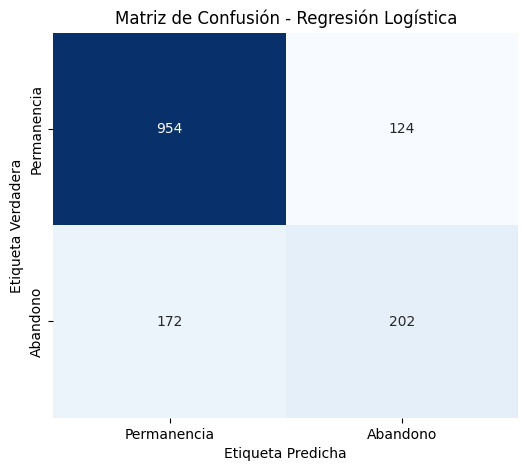

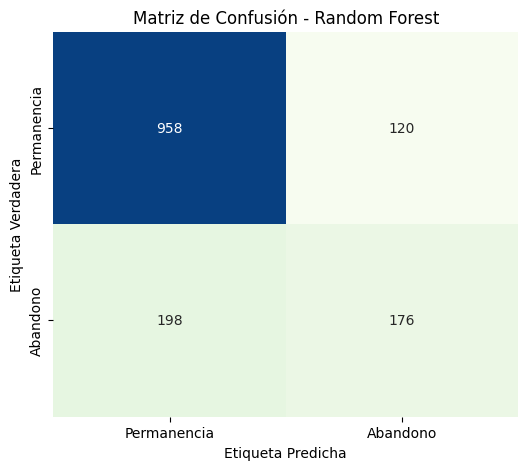

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matrices de confusión
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizar matriz de confusión para Regresión Logística con degradado azul y etiquetas en español
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Permanencia', 'Abandono'], yticklabels=['Permanencia', 'Abandono'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Visualizar matriz de confusión para Random Forest con degradado verde y etiquetas en español
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='GnBu', cbar=False,
            xticklabels=['Permanencia', 'Abandono'], yticklabels=['Permanencia', 'Abandono'])
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

## Visualización de la Importancia de las Variables

Para complementar la interpretación de los resultados, visualizaremos la importancia de las variables obtenidas de la Regresión Logística (basada en coeficientes) y del Random Forest. Esto facilitará la identificación de los factores clave que influyen en la cancelación.

/tmp/ipython-input-1417090974.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='abs_coefficient', y='feature', data=log_reg_coefficients_sorted.head(10), palette='viridis')


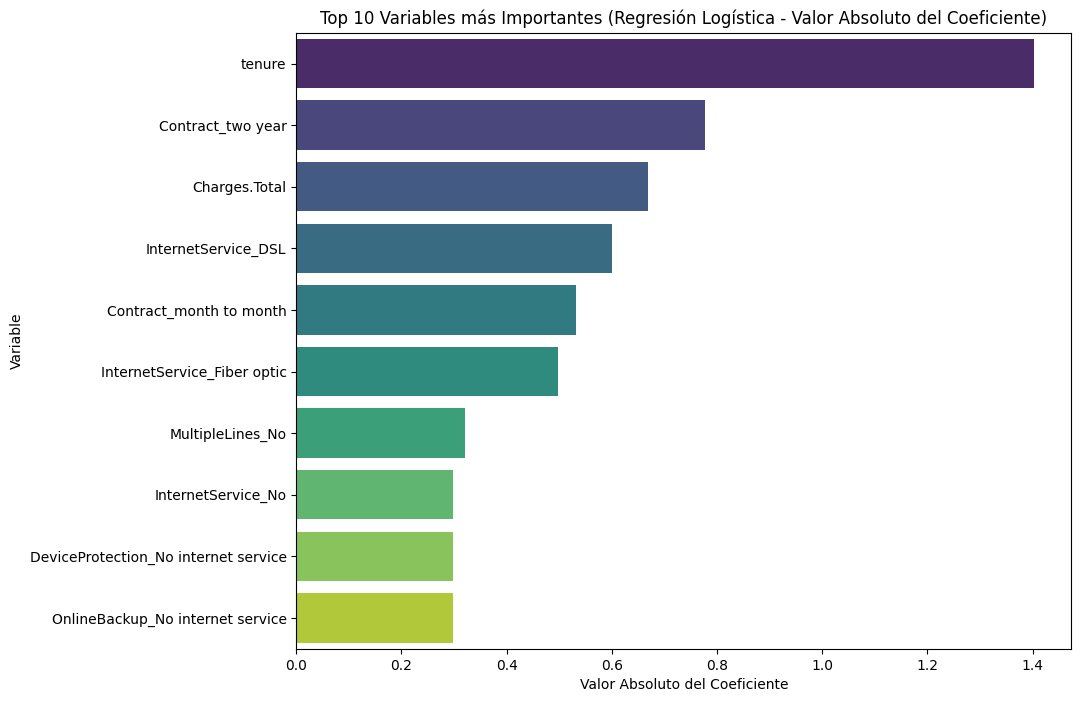

/tmp/ipython-input-1417090974.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=rf_feature_importances_sorted.head(10), palette='viridis')


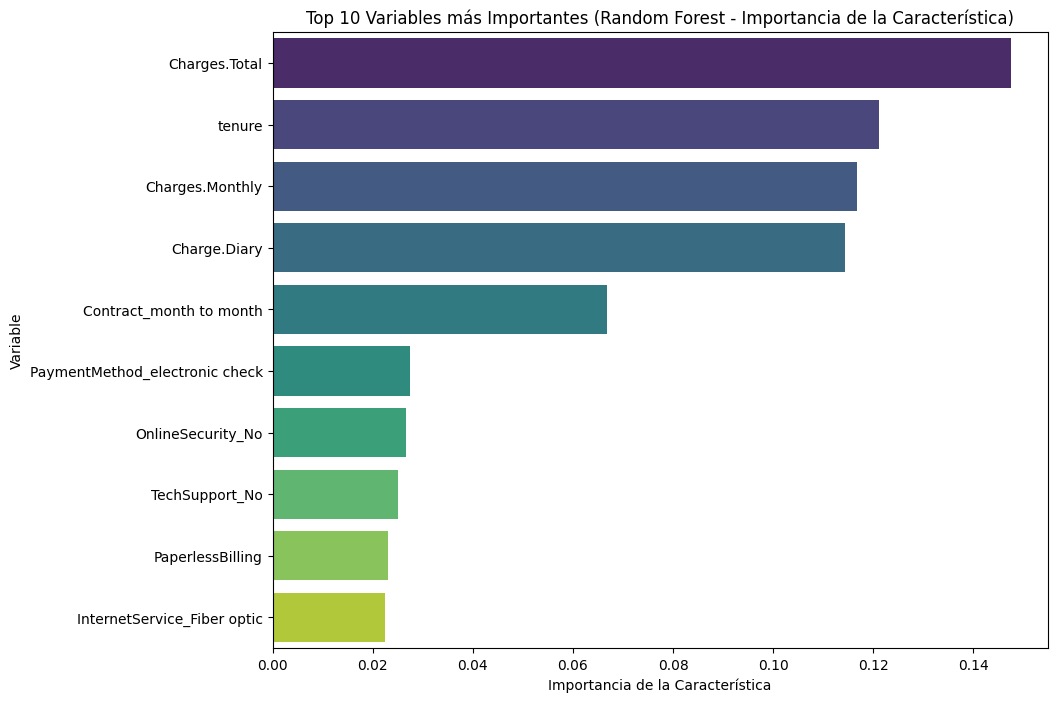

In [61]:
# Visualizar coeficientes de Regresión Logística
plt.figure(figsize=(10, 8))
sns.barplot(x='abs_coefficient', y='feature', data=log_reg_coefficients_sorted.head(10), palette='viridis')
plt.title('Top 10 Variables más Importantes (Regresión Logística - Valor Absoluto del Coeficiente)')
plt.xlabel('Valor Absoluto del Coeficiente')
plt.ylabel('Variable')
plt.show()

# Visualizar importancia de características de Random Forest
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=rf_feature_importances_sorted.head(10), palette='viridis')
plt.title('Top 10 Variables más Importantes (Random Forest - Importancia de la Característica)')
plt.xlabel('Importancia de la Característica')
plt.ylabel('Variable')
plt.show()

## Interpretación de resultados

Se analizan los resultados de la evaluación de los modelos e interpreta la importancia de las variables en los modelos que lo permitan para identificar los principales factores que influyen en la cancelación.


In [62]:
import numpy as np



# Obtener coeficientes de Regresión Logística
# Los coeficientes corresponden a las características en X_train
log_reg_coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': log_reg_model.coef_[0]
})

# Ordenar por valor absoluto del coeficiente para identificar los más importantes
log_reg_coefficients['abs_coefficient'] = abs(log_reg_coefficients['coefficient'])
log_reg_coefficients_sorted = log_reg_coefficients.sort_values(by='abs_coefficient', ascending=False)

print("Coeficientes de Regresión Logística (ordenados por valor absoluto):")
display(log_reg_coefficients_sorted.head(10)) # Mostrar las 10 variables más importantes

# Obtener importancia de características de Random Forest
rf_feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Ordenar por importancia
rf_feature_importances_sorted = rf_feature_importances.sort_values(by='importance', ascending=False)

print("\nImportancia de Características de Random Forest (ordenadas):")
display(rf_feature_importances_sorted.head(10)) # Mostrar las 10 variables más importantes


Coeficientes de Regresión Logística (ordenados por valor absoluto):


,feature,coefficient,abs_coefficient
3,tenure,-1.403458,1.403458
37,Contract_two year,-0.776412,0.776412
7,Charges.Total,0.669184,0.669184
14,InternetService_DSL,-0.599928,0.599928
35,Contract_month to month,0.531925,0.531925
15,InternetService_Fiber optic,0.497432,0.497432
11,MultipleLines_No,-0.321602,0.321602
16,InternetService_No,-0.298817,0.298817
24,DeviceProtection_No internet service,-0.298817,0.298817
21,OnlineBackup_No internet service,-0.298817,0.298817



Importancia de Características de Random Forest (ordenadas):


,feature,importance
7,Charges.Total,0.147417
3,tenure,0.121194
6,Charges.Monthly,0.116751
8,Charge.Diary,0.114338
35,Contract_month to month,0.066856
40,PaymentMethod_electronic check,0.027368
17,OnlineSecurity_No,0.026742
26,TechSupport_No,0.025081
5,PaperlessBilling,0.023037
15,InternetService_Fiber optic,0.022377


## Conclusión estratégica

En este apartado se resumen los hallazgos clave del análisis y la modelización, y presentan las conclusiones sobre los principales factores que contribuyen a la cancelación de clientes y cómo la empresa puede utilizar esta información para anticiparse al problema.


### Principales hallazgos

*   Se identificaron 31 variables con una correlación absoluta superior a 0.1 con la variable objetivo Abandono.
*   El modelo de Regresión Logística obtuvo las siguientes métricas en el conjunto de prueba: Precisión = 0.6196, Recall = 0.5401, F1-Score = 0.5771, AUC = 0.8379 y Accuracy = 0.7961.
*   El modelo de Random Forest obtuvo las siguientes métricas en el conjunto de prueba: Precisión = 0.5946, Recall = 0.4706, F1-Score = 0.5254, AUC = 0.8129 y Accuracy = 0.7810.
*   La Regresión Logística mostró un rendimiento ligeramente superior al de Random Forest en Precisión, Recall, F1-Score y AUC en este análisis.
*   Las variables más influyentes en la Regresión Logística (basado en el valor absoluto del coeficiente) incluyen `tenure`, `Contract_two year`, `Charges.Total`, `InternetService_DSL` y `Contract_month to month`.
*   Las variables más importantes en Random Forest (basado en la importancia de las características) incluyen `Charges.Total`, `tenure`, `Charges.Monthly`, `Charge.Diary` y `Contract_month to month`.
*   Variables como `tenure`, `Charges.Total` y `Contract_month to month` fueron consistentes como factores importantes en ambos modelos.

### Insights

*   Telecom X debe enfocar sus esfuerzos de retención en clientes con baja antigüedad, aquellos con contratos mensuales y los que utilizan métodos de pago específicos o ciertos servicios, ya que estos son los factores de riesgo más consistentes identificados por los modelos.
*   Se recomienda explorar técnicas adicionales de selección de variables, como la eliminación recursiva de características o métodos basados en modelos, para optimizar los modelos y potentially mejorar su rendimiento y interpretabilidad.


## Interpretación de los Resultados y Conclusión Estratégica

Basándonos en las métricas de evaluación obtenidas para ambos modelos y en el análisis de la importancia de las variables, podemos extraer las siguientes conclusiones clave:

*   **Comparación de Modelos:** El modelo de Regresión Logística tuvo un rendimiento ligeramente superior en la mayoría de las métricas de evaluación (Precisión, Recall, F1-Score y AUC) en comparación con el modelo de Random Forest en este conjunto de datos. Esto sugiere que, para este problema particular, la Regresión Logística pudo capturar mejor la relación entre las características y la probabilidad de cancelación.

*   **Factores Clave de Cancelación:** La interpretación de los coeficientes de la Regresión Logística y la importancia de las características del Random Forest revelan consistentemente que la **antigüedad del cliente (tenure)**, el **tipo de contrato (especialmente contratos mes a mes frente a contratos a largo plazo)** y los **cargos totales (Charges.Total)** o **cargos mensuales (Charges.Monthly)** son los predictores más importantes de la cancelación. Otras variables relevantes incluyen el tipo de servicio de Internet (Fibra Óptica vs DSL vs No Internet) y ciertos métodos de pago (como el cheque electrónico).

*   **Implicaciones Estratégicas:** Para reducir la tasa de cancelación, Telecom X debería centrar sus esfuerzos en los siguientes grupos de clientes y áreas:
    *   **Clientes con baja antigüedad:** Implementar programas de incorporación o incentivos especiales para retener a los clientes en sus primeros meses.
    *   **Clientes con contratos mensuales:** Ofrecer opciones de actualización a contratos a más largo plazo con beneficios adicionales para fomentar la lealtad.
    *   **Clientes con altos cargos mensuales o totales:** Investigar si estos cargos están alineados con el valor percibido por el cliente y considerar ofrecer planes o paquetes más atractivos.
    *   **Clientes con servicio de Fibra Óptica o pago con cheque electrónico:** Analizar si hay problemas específicos asociados con estos servicios o métodos de pago que estén contribuyendo a la cancelación y tomar medidas correctivas.

*   **Próximos Pasos:** Si bien los modelos actuales proporcionan información valiosa, se podrían explorar técnicas adicionales como la ingeniería de características más avanzada, la consideración de otros modelos (como Gradient Boosting) o la implementación de estrategias de manejo de desbalance de clases para potencialmente mejorar aún más la capacidad predictiva y la interpretabilidad.

En resumen, este análisis inicial ha identificado los principales impulsores de la cancelación de clientes en Telecom X, que va en línea con lo obtenido el análisis descriptivo, por ende proporciona una base sólida para desarrollar estrategias de retención de clientes más específicas y efectivas.

## Fin del Análisis Predictivo de Evasión de Clientes

Con este análisis, hemos logrado los objetivos planteados:

*   Los datos fueron preparados adecuadamente para el modelado.
*   Se realizó un análisis de correlación para identificar variables relevantes.
*   Se entrenaron y evaluaron dos modelos de clasificación (Regresión Logística y Random Forest).
*   Se interpretaron los resultados, incluyendo la importancia de las variables, para identificar los principales impulsores de la cancelación.
*   Se formularon conclusiones estratégicas basadas en los hallazgos para ayudar a Telecom X a anticipar y mitigar la evasión de clientes.

Este trabajo proporciona una base sólida para futuras iniciativas de retención de clientes basadas en inteligencia predictiva.